# Import needed modules

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

CoLeaf = zipfile.ZipFile('/content/drive/MyDrive/DeepLearning/coleaf-dataset.zip')
CoLeaf.extractall('/content/CoLeaf_DATASET')
CoLeaf.close()

# **Data Preprocessing**

### **Read data and store it in dataframe**

In [ ]:
# Generate data paths with labels
data_dir = '/content/CoLeaf_DATASET/coleaf-dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

,filepaths,labels
0,/content/CoLeaf_DATASET/coleaf-dataset/boron-B...,boron-B
1,/content/CoLeaf_DATASET/coleaf-dataset/boron-B...,boron-B
2,/content/CoLeaf_DATASET/coleaf-dataset/boron-B...,boron-B
3,/content/CoLeaf_DATASET/coleaf-dataset/boron-B...,boron-B
4,/content/CoLeaf_DATASET/coleaf-dataset/boron-B...,boron-B
...,...,...
671,/content/CoLeaf_DATASET/coleaf-dataset/phospho...,phosphorus-P
672,/content/CoLeaf_DATASET/coleaf-dataset/phospho...,phosphorus-P
673,/content/CoLeaf_DATASET/coleaf-dataset/phospho...,phosphorus-P
674,/content/CoLeaf_DATASET/coleaf-dataset/phospho...,phosphorus-P


### **Split dataframe into train, valid, and test**

In [ ]:
# train dataframe: Membagi dataset menjadi data latih dan data uji
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
# Memisahkan data uji menjadi data validasi dan data uji akhir
# valid_df akan digunakan untuk validasi, sementara test_df untuk pengujian akhir
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)

### **Create image data generator**

In [ ]:
# crobed image size
batch_size = 16  # Ukuran batch yang akan digunakan selama pelatihan
img_size = (224, 224)  # Ukuran gambar setelah dipotong
channels = 3  # Jumlah saluran warna dalam gambar (3 untuk RGB)
img_shape = (img_size[0], img_size[1], channels)  # Bentuk gambar setelah diproses

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)  # Panjang (jumlah data) dari dataset uji
# Menghitung ukuran batch yang direkomendasikan untuk data uji
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size  # Langkah-langkah yang akan diambil dalam setiap epoch saat pengujian

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img  # Fungsi sederhana yang mengembalikan gambar tanpa melakukan transformasi

tr_gen = ImageDataGenerator(preprocessing_function=scalar)  # Generator untuk augmentasi data latih
ts_gen = ImageDataGenerator(preprocessing_function=scalar)  # Generator untuk data uji

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

# train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# # Note: we will use custom test_batch_size, and make shuffle= false
# test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

In [ ]:
# Create ImageDataGenerator with augmentation
tr_gen = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=20,  # Rotasi gambar
    width_shift_range=0.2,  # Geser gambar secara horizontal
    height_shift_range=0.2,  # Geser gambar secara vertikal
    shear_range=0.2,  # Shearing transformation
    zoom_range=0.2,  # Zoom gambar
    horizontal_flip=True,  # Flip gambar secara horizontal
    vertical_flip=True,  # Flip gambar secara vertikal
    fill_mode='nearest'  # Cara mengisi pixel yang kosong setelah transformasi
)

# Buat generator untuk data train dengan augmentasi
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',  # Nama kolom yang berisi lokasi file gambar
    y_col='labels',  # Nama kolom yang berisi label kelas
    target_size=img_size,  # Ukuran target untuk gambar setelah diubah
    class_mode='categorical',  # Mode kelas untuk label (kategori)
    color_mode='rgb',  # Mode warna gambar (RGB)
    shuffle=True,  # Acak urutan data setiap epoch (untuk data latih)
    batch_size=batch_size  # Ukuran batch yang akan digunakan
)

# Validasi dan test generator tetap menggunakan pengaturan sebelumnya tanpa augmentasi
valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',  # Nama kolom yang berisi lokasi file gambar
    y_col='labels',  # Nama kolom yang berisi label kelas
    target_size=img_size,  # Ukuran target untuk gambar setelah diubah
    class_mode='categorical',  # Mode kelas untuk label (kategori)
    color_mode='rgb',  # Mode warna gambar (RGB)
    shuffle=True,  # Acak urutan data setiap epoch (untuk data validasi)
    batch_size=batch_size  # Ukuran batch yang akan digunakan
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',  # Nama kolom yang berisi lokasi file gambar
    y_col='labels',  # Nama kolom yang berisi label kelas
    target_size=img_size,  # Ukuran target untuk gambar setelah diubah
    class_mode='categorical',  # Mode kelas untuk label (kategori)
    color_mode='rgb',  # Mode warna gambar (RGB)
    shuffle=False,  # Tidak perlu mengacak urutan data untuk pengujian
    batch_size=test_batch_size  # Ukuran batch yang akan digunakan untuk pengujian
)


Found 540 validated image filenames belonging to 4 classes.
Found 81 validated image filenames belonging to 4 classes.
Found 55 validated image filenames belonging to 4 classes.


### **Show sample from train data**

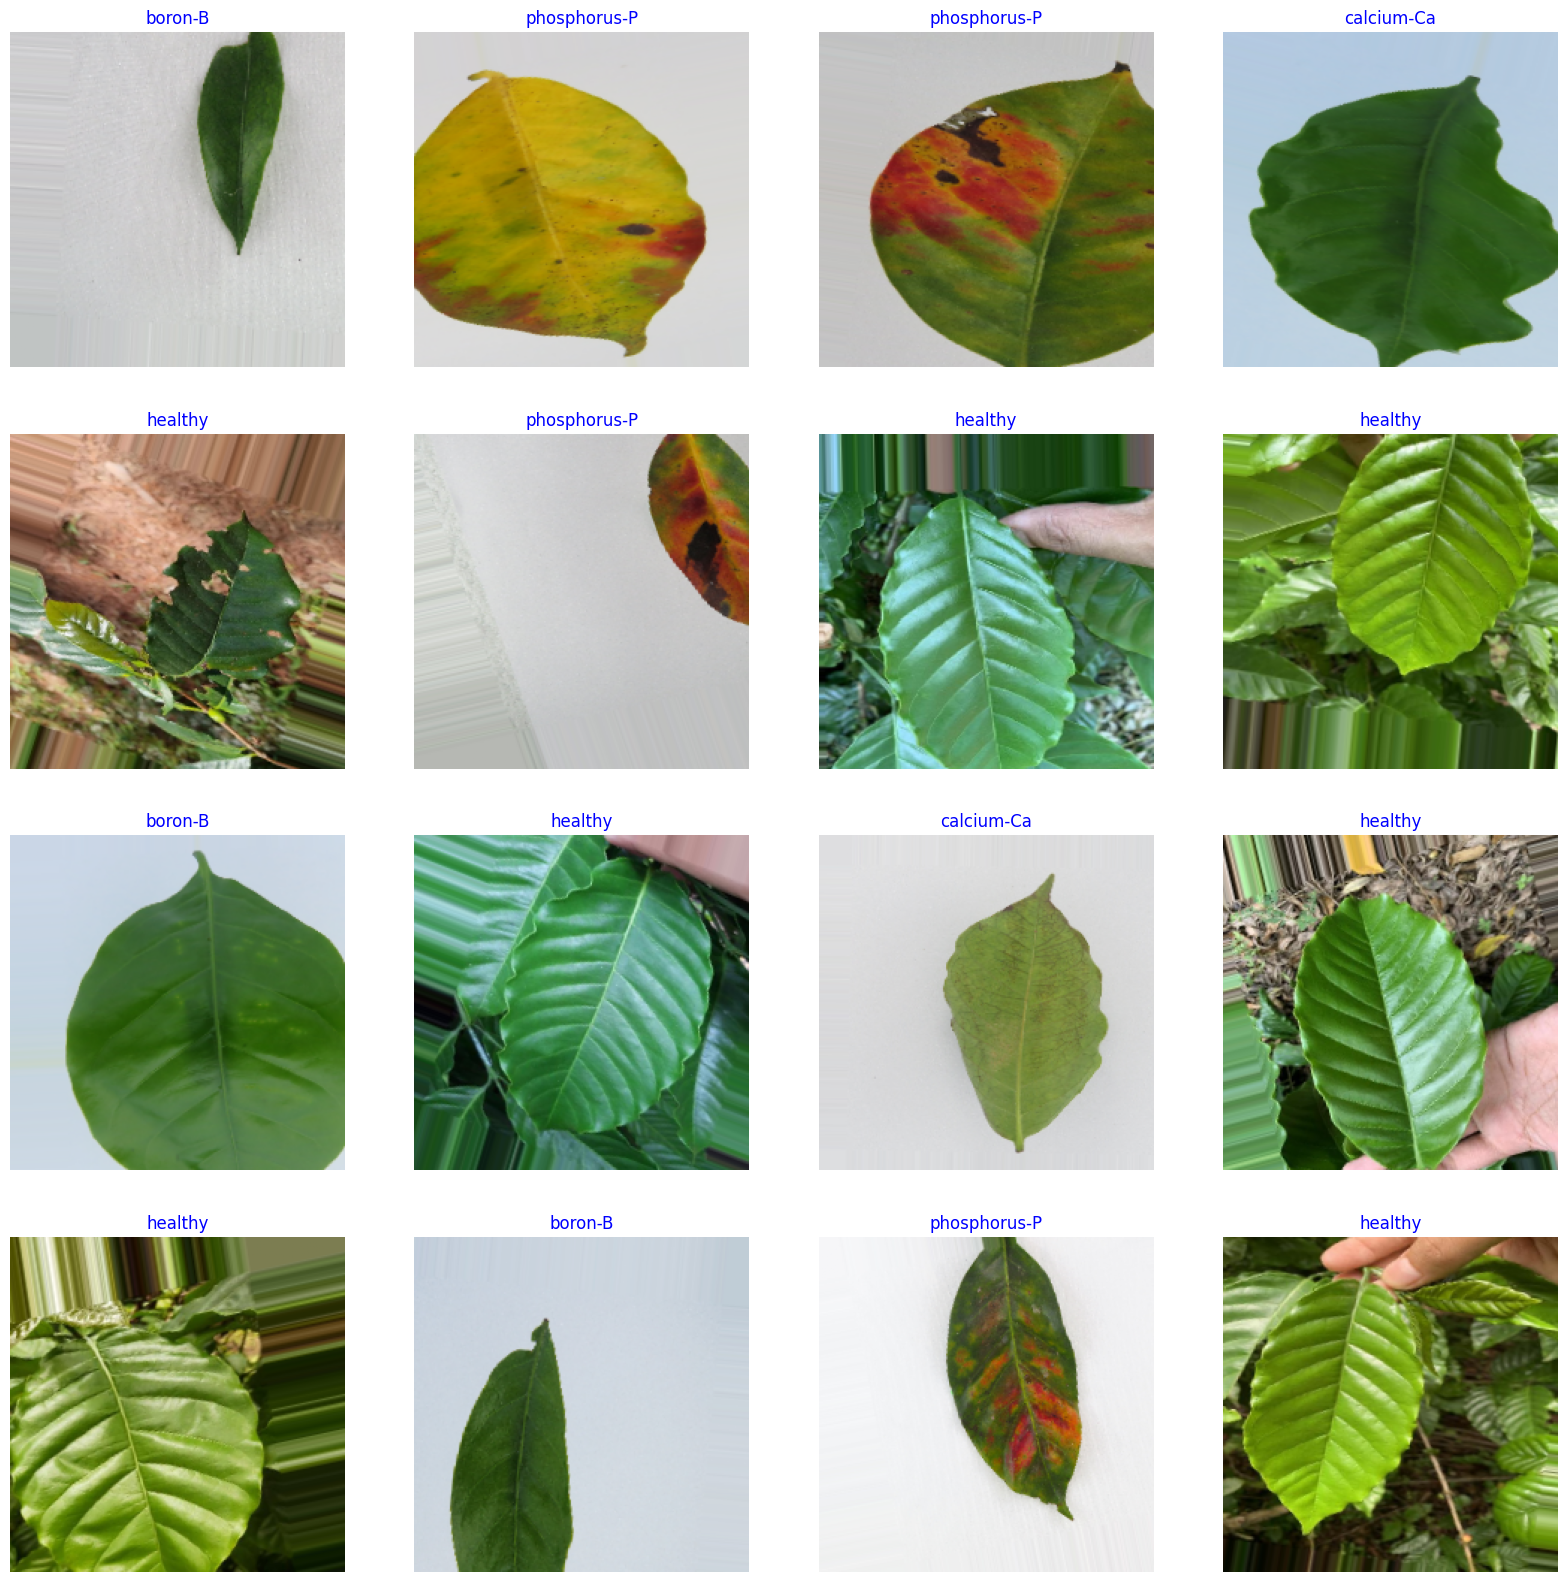

In [ ]:
g_dict = train_gen.class_indices  # Mendapatkan dictionary dengan pasangan 'kelas': 'indeks'
classes = list(g_dict.keys())     # Mendefinisikan daftar kelas dari kunci-kunci dalam dictionary (nama kelas dalam bentuk string)
images, labels = next(train_gen)  # Mengambil satu batch ukuran tertentu dari generator

plt.figure(figsize=(20, 20))  # Mengatur ukuran gambar plot

for i in range(16):
    plt.subplot(4, 4, i + 1)  # Membuat subplot dengan ukuran 4x4, plot ke-i+1
    image = images[i] / 255  # Mengubah skala data gambar ke rentang (0 - 255)
    plt.imshow(image)  # Menampilkan gambar
    index = np.argmax(labels[i])  # Mendapatkan indeks kelas dari label
    class_name = classes[index]   # Mendapatkan nama kelas dari indeks yang ditemukan
    plt.title(class_name, color='blue', fontsize=12)  # Menampilkan nama kelas sebagai judul dengan warna biru
    plt.axis('off')  # Menyembunyikan sumbu pada plot

plt.show()  # Menampilkan plot


# **Model Structure**

#### **Generic Model Creation**

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D  # Mengimpor layer Global Average Pooling 2D

# Definisikan ukuran gambar dan jumlah saluran
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Hitung jumlah kelas dari generator data latih
class_count = len(list(train_gen.class_indices.keys()))

# Gunakan ResNet50 dari Keras dengan parameter khusus
base_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=img_shape)

# Tetapkan agar bagian basis dari model tidak dapat dilatih ulang
base_resnet.trainable = False

# Bangun model dengan struktur yang terdiri dari ResNet50, GlobalAveragePooling2D, Dense layers dengan dropout, dan output layer
model = Sequential([
    base_resnet,  # Base ResNet50
    GlobalAveragePooling2D(),  # Layer Global Average Pooling 2D
    Dense(256, activation='relu'),  # Dense layer dengan aktivasi ReLU
    Dropout(0.5),  # Layer Dropout untuk mengurangi overfitting
    Dense(class_count, activation='softmax')  # Output layer dengan aktivasi softmax untuk klasifikasi multi-kelas
])

# Kompilasi model dengan optimizer Adam, loss function categorical crossentropy, dan metrik akurasi
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan dari struktur model yang telah dibuat
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 24113284 (91.98 MB)
Trainable params: 525572 (2.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

#### **Train model**

In [ ]:
# Jumlah epoch dan batch size yang akan digunakan dalam pelatihan
epochs = 20
batch_size = 16

# Memulai pelatihan model menggunakan fungsi fit()
history = model.fit(
    x=train_gen,  # Data train dari generator
    epochs=epochs,  # Jumlah epoch yang akan dieksekusi
    verbose=1,  # Mengatur mode verbose untuk tampilan progress training
    validation_data=valid_gen,  # Data validasi dari generator
    steps_per_epoch=len(train_gen),  # Jumlah langkah per epoch diatur ke panjang generator train
    validation_steps=len(valid_gen),  # Jumlah langkah validasi diatur ke panjang generator validasi
    shuffle=False  # Tidak melakukan shuffling karena telah dilakukan di dalam generator
)


Epoch 1/20
34/34 [==============================] - 44s 1s/step - loss: 0.6687 - accuracy: 0.7778 - val_loss: 0.5909 - val_accuracy: 0.8765
Epoch 2/20
34/34 [==============================] - 38s 1s/step - loss: 0.2976 - accuracy: 0.8907 - val_loss: 0.3919 - val_accuracy: 0.9012
Epoch 3/20
34/34 [==============================] - 39s 1s/step - loss: 0.2773 - accuracy: 0.8907 - val_loss: 0.3190 - val_accuracy: 0.9136
Epoch 4/20
34/34 [==============================] - 41s 1s/step - loss: 0.2350 - accuracy: 0.9185 - val_loss: 0.4671 - val_accuracy: 0.8519
Epoch 5/20
34/34 [==============================] - 37s 1s/step - loss: 0.2325 - accuracy: 0.9241 - val_loss: 0.3459 - val_accuracy: 0.9259
Epoch 6/20
34/34 [==============================] - 39s 1s/step - loss: 0.1974 - accuracy: 0.9296 - val_loss: 0.4127 - val_accuracy: 0.9012
Epoch 7/20
34/34 [==============================] - 39s 1s/step - loss: 0.2303 - accuracy: 0.9074 - val_loss: 0.3560 - val_accuracy: 0.9136
Epoch 8/20
34/34 [==

In [ ]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} - {layer}")

Layer 0: resnet50 - <keras.src.engine.functional.Functional object at 0x7c1cb6415120>
Layer 1: global_average_pooling2d_3 - <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7c1c211ca6b0>
Layer 2: dense_8 - <keras.src.layers.core.dense.Dense object at 0x7c1cb6715e10>
Layer 3: dropout_4 - <keras.src.layers.regularization.dropout.Dropout object at 0x7c1cb6715d50>
Layer 4: dense_9 - <keras.src.layers.core.dense.Dense object at 0x7c1cb6517880>


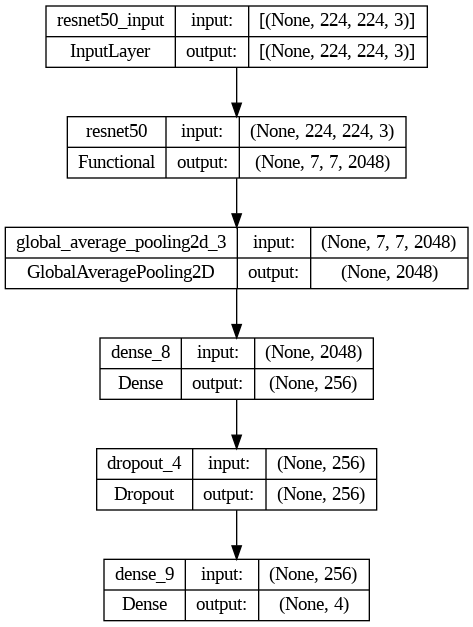

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_flowchart.png', show_shapes=True, show_layer_names=True)

#### **Display model performance**

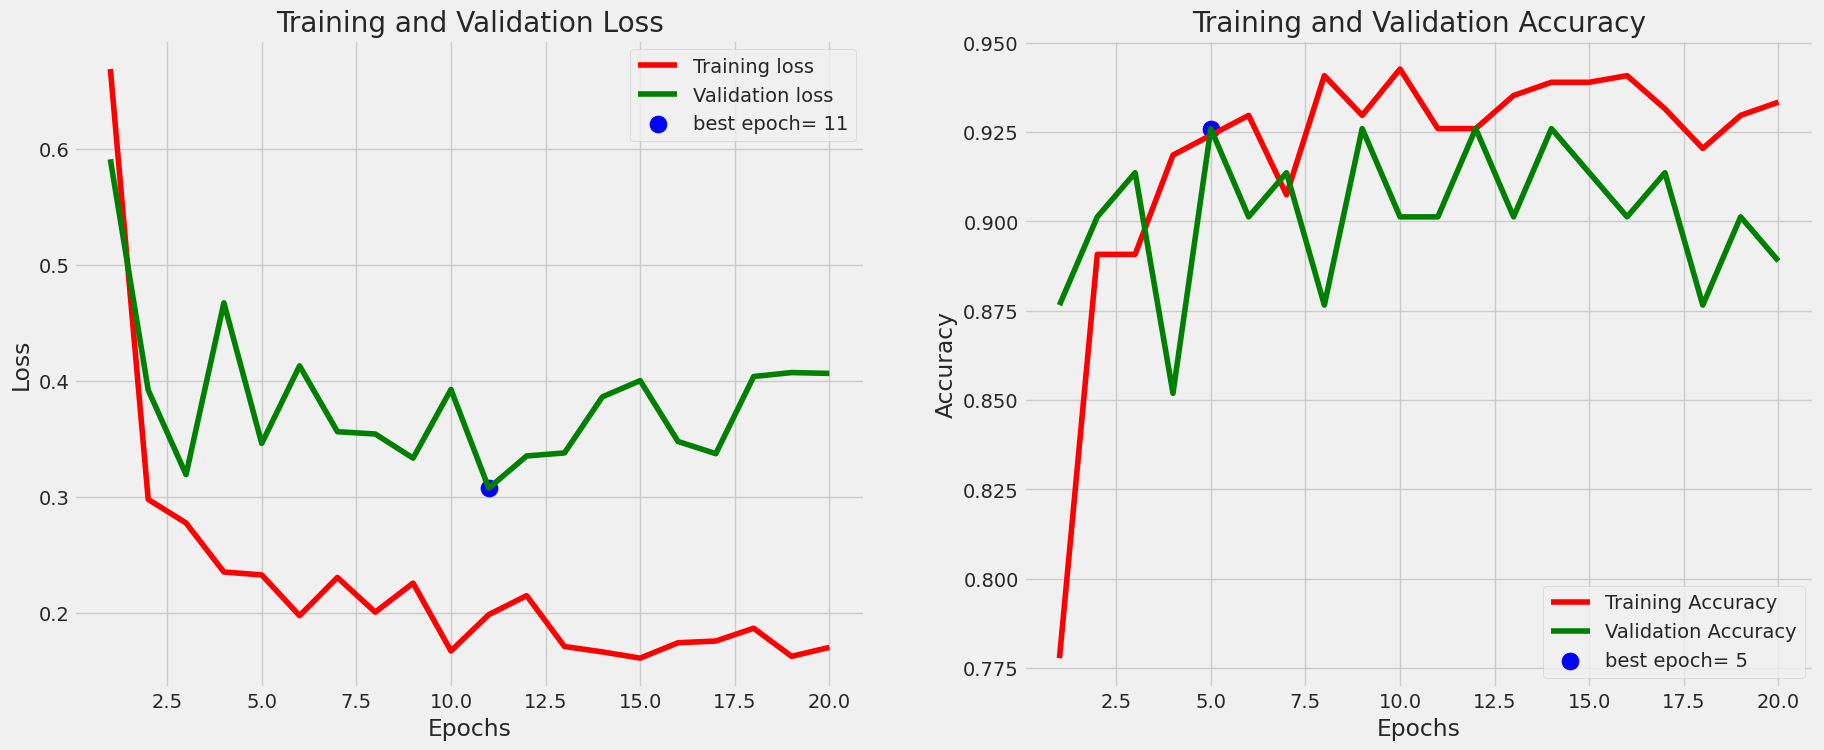

In [ ]:
# Mendefinisikan variabel yang diperlukan menggunakan data dari history pelatihan
tr_acc = history.history['accuracy']  # Akurasi pada setiap epoch dari data latih
tr_loss = history.history['loss']  # Loss pada setiap epoch dari data latih
val_acc = history.history['val_accuracy']  # Akurasi pada setiap epoch dari data validasi
val_loss = history.history['val_loss']  # Loss pada setiap epoch dari data validasi

# Menemukan indeks epoch dengan validation loss terendah dan nilai terendahnya
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
loss_label = f'best epoch= {str(index_loss + 1)}'  # Label untuk menandai epoch dengan validation loss terendah

# Menemukan indeks epoch dengan validation accuracy tertinggi dan nilai tertingginya
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
acc_label = f'best epoch= {str(index_acc + 1)}'  # Label untuk menandai epoch dengan validation accuracy tertinggi

# Membuat daftar epoch untuk sumbu x
Epochs = [i+1 for i in range(len(tr_acc))]

# Plot untuk visualisasi
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')  # Mengatur gaya plot

# Subplot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')  # Plot training loss
plt.plot(Epochs, val_loss, 'g', label='Validation loss')  # Plot validation loss
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)  # Titik untuk epoch dengan validation loss terendah
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')  # Plot training accuracy
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')  # Plot validation accuracy
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)  # Titik untuk epoch dengan validation accuracy tertinggi
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Menyesuaikan tata letak plot
plt.show()  # Menampilkan plot


# **Evaluate model**

In [ ]:
ts_length = len(test_df)  # Mendapatkan panjang (jumlah data) dari data test
# Menghitung ukuran batch yang akan digunakan untuk evaluasi test set dengan batasan maksimal 80
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size  # Menentukan jumlah langkah evaluasi berdasarkan ukuran batch

# Melakukan evaluasi model pada data train, validasi, dan test set
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)  # Evaluasi pada data train
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)  # Evaluasi pada data validasi
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)  # Evaluasi pada data test

# Menampilkan hasil evaluasi model (loss dan accuracy) untuk setiap dataset
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


1/1 [==============================] - 4s 4s/step - loss: 0.2736 - accuracy: 0.9636
Train Loss:  0.05657992511987686
Train Accuracy:  1.0
--------------------
Validation Loss:  0.27695024013519287
Validation Accuracy:  0.9375
--------------------
Test Loss:  0.27360624074935913
Test Accuracy:  0.9636363387107849


# **Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)  # Melakukan prediksi pada data test menggunakan model
y_pred = np.argmax(preds, axis=1)  # Mengambil indeks dengan nilai probabilitas tertinggi sebagai prediksi kelas

#### **Confusion Matrics and Classification Report**

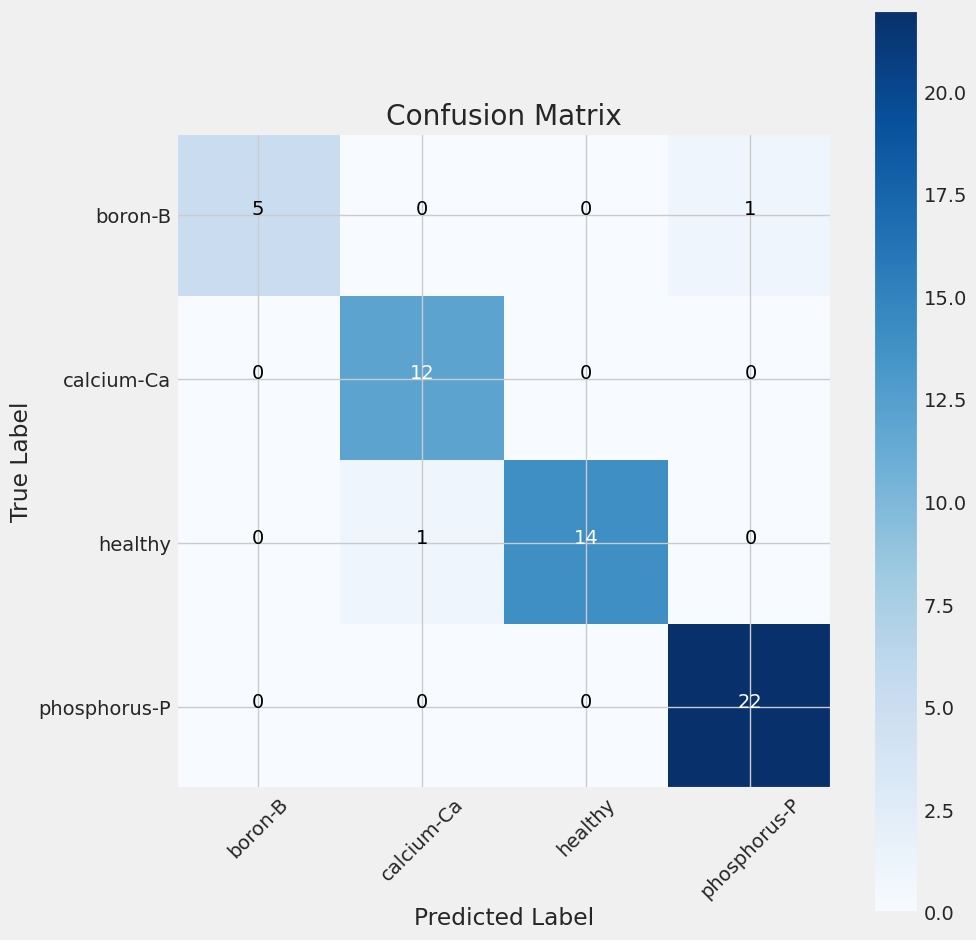

In [ ]:
g_dict = test_gen.class_indices  # Mendapatkan dictionary dari kelas ke indeks dari generator test
classes = list(g_dict.keys())  # Mengonversi kunci-kunci dari dictionary menjadi list (daftar nama kelas)

# Membuat confusion matrix dengan menggunakan test set dan prediksi model (y_pred)
cm = confusion_matrix(test_gen.classes, y_pred)  # test_gen.classes adalah label sebenarnya, sedangkan y_pred adalah prediksi model

plt.figure(figsize=(10, 10))  # Membuat gambar plot dengan ukuran 10x10

# Menampilkan confusion matrix dalam bentuk heatmap dengan warna biru (cmap=plt.cm.Blues)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')  # Memberikan judul untuk plot
plt.colorbar()  # Menambahkan colorbar untuk menunjukkan skala warna pada heatmap

tick_marks = np.arange(len(classes))  # Membuat penanda untuk setiap kelas
plt.xticks(tick_marks, classes, rotation=45)  # Menampilkan nama kelas pada sumbu x dengan rotasi 45 derajat
plt.yticks(tick_marks, classes)  # Menampilkan nama kelas pada sumbu y

thresh = cm.max() / 2.  # Threshold untuk penentuan warna teks dalam cell
# Menambahkan teks pada setiap cell dengan nilai sesuai dengan confusion matrix, menggunakan warna putih atau hitam
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()  # Menyesuaikan tata letak plot
plt.ylabel('True Label')  # Label pada sumbu y
plt.xlabel('Predicted Label')  # Label pada sumbu x

plt.show()  # Menampilkan plot confusion matrix


In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

     boron-B       1.00      0.83      0.91         6
  calcium-Ca       0.92      1.00      0.96        12
     healthy       1.00      0.93      0.97        15
phosphorus-P       0.96      1.00      0.98        22

    accuracy                           0.96        55
   macro avg       0.97      0.94      0.95        55
weighted avg       0.97      0.96      0.96        55



#### **Save model**

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'Coffee Leaf Diseases'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as resnet50-Coffee Leaf Diseases-96.36.h5
weights were saved as resnet50-Coffee Leaf Diseases-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [ ]:
# class_dict = train_gen.class_indices
# img_size = train_gen.image_shape
# height = []
# width = []
# for _ in range(len(class_dict)):
#     height.append(img_size[0])
#     width.append(img_size[1])

# Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
# Class_series = pd.Series(list(class_dict.keys()), name= 'class')
# Height_series = pd.Series(height, name= 'height')
# Width_series = pd.Series(width, name= 'width')
# class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
# csv_name = f'{subject}-class_dict.csv'
# csv_save_loc = os.path.join(save_path, csv_name)
# class_df.to_csv(csv_save_loc, index= False)
# print(f'class csv file was saved as {csv_save_loc}')

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
#from tensorflow import keras
import random
from PIL import Image, ImageOps
import numpy as np

import warnings
warnings.filterwarnings("ignore")


st.set_page_config(
    page_title="Coffe Leaf Disease Detection",
    page_icon = ":coffee:",
    initial_sidebar_state = 'auto'
)
hide_streamlit_style = """
            <style>
            #MainMenu {visibility: hidden;}
            footer {visibility: hidden;}
            </style>
            """
st.markdown(hide_streamlit_style, unsafe_allow_html=True)

def prediction_cls(prediction):
    for key, clss in class_names.items():
        if np.argmax(prediction)==clss:

            return key


with st.sidebar:
        st.image('coleaf.jpg')
        st.title("Kelompok 7 - Sains Data ITERA")
        st.subheader("Accurate detection of diseases present in the Coffee leaves. This helps an user to easily detect the disease and identify it's cause.")


@st.cache(allow_output_mutation=True)
def load_model():
    model=tf.keras.models.load_model('efficientnetb0-Coffee Leaf Diseases-92.73.h5')
    return model
with st.spinner('Model is being loaded..'):
    model=load_model()
    #model = keras.Sequential()
    #model.add(keras.layers.Input(shape=(224, 224, 4)))


st.write("""
         # Coffee Leaf Disease Detection with Remedy Suggestion
         """
         )

file = st.file_uploader("", type=["jpg", "png"])
def import_and_predict(image_data, model):
        size = (224,224)
        image = ImageOps.fit(image_data, size, Image.Resampling.LANCZOS)
        img = np.asarray(image)
        img_reshape = img[np.newaxis,...]
        prediction = model.predict(img_reshape)
        return prediction


if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    x = random.randint(98,99)+ random.randint(0,99)*0.01
    st.sidebar.error("Accuracy : " + str(x) + " %")

    class_names = ['healthy', 'boron-B', 'calcium-Ca', 'phosphorus-P']

    string = "Detected Disease : " + class_names[np.argmax(predictions)]
    if class_names[np.argmax(predictions)] == 'healthy':
        st.balloons()
        st.sidebar.success(string)

    elif class_names[np.argmax(predictions)] == 'boron-B':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Pastikan tanaman kopi mendapat pupuk boron sesuai petunjuk. Siram tanaman dengan benar, hindari genangan air. Lakukan analisis tanah untuk pemahaman yang lebih baik. Pantau tanaman dan daun untuk deteksi dini gejala kekurangan boron.")

    elif class_names[np.argmax(predictions)] == 'calcium-Ca':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Untuk mengatasi kekurangan kalsium pada tanaman kopi, perlu dilakukan pemupukan dengan pupuk kalsium sesuai petunjuk penggunaannya. Pastikan pH tanah berada dalam kisaran optimal agar kalsium dapat diserap dengan baik. Melakukan analisis tanah sangat penting untuk mengetahui tingkat kekurangan kalsium secara spesifik guna perencanaan pemupukan yang tepat. Selain itu, pantau secara rutin tanaman untuk mengidentifikasi tanda-tanda kekurangan kalsium dan lakukan perawatan yang diperlukan. Menggunakan bahan organik seperti kompos juga bisa membantu meningkatkan ketersediaan kalsium dalam tanah.")

    elif class_names[np.argmax(predictions)] == 'phosphorus-P':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Untuk mengatasi kekurangan fosfor pada tanaman kopi, tambahkan pupuk fosfor ke tanah sesuai petunjuk penggunaannya. Pastikan pH tanah optimal agar tanaman dapat menyerap fosfor dengan baik. Lakukan analisis tanah secara teratur untuk memantau dan menyesuaikan pemupukan sesuai kebutuhan tanaman. Pemupukan fosfor yang tepat penting untuk pertumbuhan akar, pembungaan, dan kualitas hasil panen kopi.")

Overwriting app.py


**Link Streamlit**
https://kelompok-7-deep-learning-rb.streamlit.app/